# Banknote serial number recognition

A system for banknote serial number recognition.

## Prerequsites

#### Importing modules

In [1]:
import os
import re
import glob
import random
from collections import defaultdict
from typing import Tuple
from datetime import datetime

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imgaug as ia
from PIL import Image
from tensorflow.keras import layers, models

tf.__version__

'2.1.0'

#### Configuration

In [2]:
train_locations = [
    "./dataset/SNRdataset/EUR/train",
    "./dataset/SNRdataset/JPY_1K_5K/train",
    "./dataset/SNRdataset/JPY_2K_10K/train",
    "./dataset/SNRdataset/KRW/train"
]

test_locations = [
    "./dataset/SNRdataset/EUR/test",
    "./dataset/SNRdataset/JPY_1K_5K/test",
    "./dataset/SNRdataset/JPY_2K_10K/test",
    "./dataset/SNRdataset/KRW/test"
]

BATCH_SIZE = 128
EPOCHS = 128
IMAGE_SHAPE = (160, 48)
CHARACTER_SHAPE = (16, 16)

#### Downloading dataset

In [3]:
!/bin/sh ./get_dataset.sh

Cloning into 'dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39390 (delta 2), reused 0 (delta 0), pack-reused 39381
Receiving objects: 100% (39390/39390), 261.00 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (39355/39355), done.


## Exploring image data

#### Loading data
Going through every directory in the dataset and loading all the images into numpy arrays using Pillow.

In [4]:
def load_data(locations: str):
    data = []
    for location in locations:
        for path in glob.glob(location + "/*"):
            image = np.array(Image.open(path).convert('L'), dtype=np.uint8)
            serial = os.path.splitext(os.path.basename(path))[0].split('_')[-1].replace('z', '')
            dataset = location.split('/')[-2]

            data.append({"image": image, "serial": serial, "dataset": dataset})

    return data

In [5]:
train_data = load_data(train_locations)
test_data = load_data(test_locations)

#### Preview a subset of the data
Plotting a random subset of 25 serial number images and their labeling to verify if they are loaded properly.

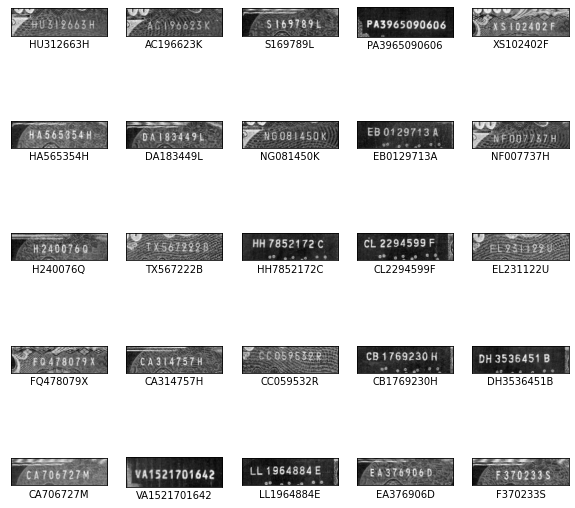

In [6]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_index = random.randint(0, len(train_data))
    plt.imshow(train_data[image_index]["image"], cmap=plt.cm.binary)
    plt.xlabel(train_data[image_index]["serial"])
plt.show()

#### Data distribution
A bar chart displaying the number of Train/Test images in each category.

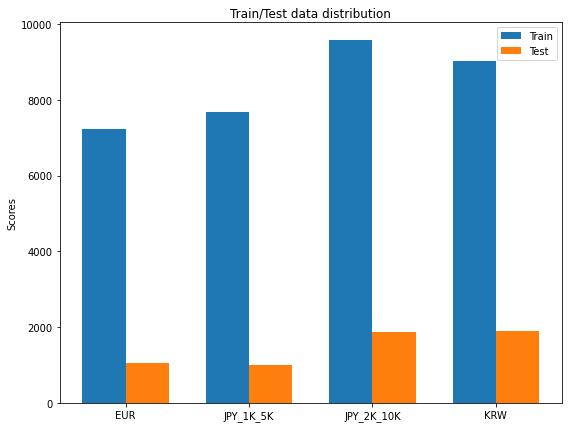

In [7]:
train_means = [len(glob.glob(path + '/*')) for path in train_locations]
test_means = [len(glob.glob(path + '/*')) for path in test_locations]

ind = np.arange(len(train_locations)) 
plt.figure(figsize=(9, 7))
width = 0.35       
plt.bar(ind, train_means, width, label='Train')
plt.bar(ind + width, test_means, width,
    label='Test')

plt.ylabel('Scores')
plt.title('Train/Test data distribution')

plt.xticks(ind + width / 2, [path.split('/')[-2] for path in train_locations])
plt.legend(loc='best')
plt.show()

#### Image resolution distribution
A bar chart containing all the image resolutions within the dataset. Whether there is more than one column, images should be resized.

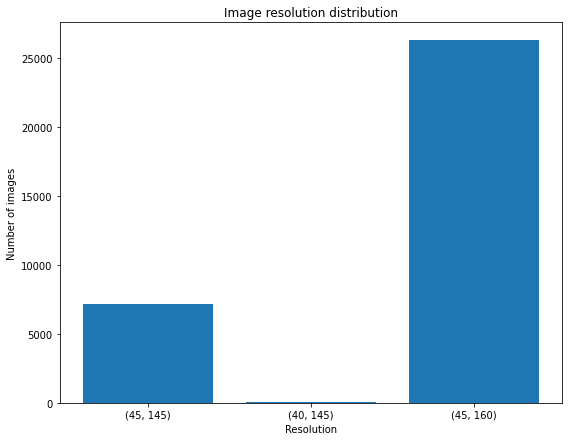

In [8]:
resolutions = defaultdict(lambda: 0)
for item in train_data:
    resolutions[item["image"].shape] += 1

x = resolutions.keys()
energy = resolutions.values()

x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(9, 7))
plt.bar(x_pos, energy)
plt.xlabel("Resolution")
plt.ylabel("Number of images")
plt.title("Image resolution distribution")

plt.xticks(x_pos, x)

plt.show()

## Characterset definition + Serial encoding

#### Defining characterset

In [9]:
characterset = []
for item in train_data + test_data:
    for letter in item['serial']:
        if letter not in characterset:
            characterset.append(letter)
            
characterset.sort()

#### Serial number encoding

In [10]:
def serial_encode_dataset(dataset):
    for i, item in enumerate(dataset):
        new_serial = np.zeros(max_str_length)
        for j, letter in enumerate(item['serial']):
            new_serial[j] = characterset.index(letter) + 1
        
        dataset[i]['serial'] = new_serial

#### Serial number decoding

In [11]:
def serial_decode(serial):
    serial = list(serial)
    return characterset[serial.index(max(serial))]

## Character separation

#### Convert data in numpy arrays
Loading the list data into ndarrays and resizing images for a consistent array shape.

In [12]:
def convert_to_ndarrays(dataset: list, image_shape: tuple):
    # Resizing images and loading them into an array
    image_array = np.array([
        cv2.resize(item["image"], dsize=image_shape, interpolation=cv2.INTER_CUBIC)
        for item in dataset], dtype=np.uint8)

    # Loading serial numbers into an array
    serials_array = np.array([item["serial"] for item in dataset])
    dataset_array = np.array([item["dataset"] for item in dataset])

    return image_array, serials_array, dataset_array

In [13]:
train_data = convert_to_ndarrays(train_data, IMAGE_SHAPE)
test_data = convert_to_ndarrays(test_data, IMAGE_SHAPE)

train_data[0].shape, train_data[1].shape, train_data[2].shape

((33502, 48, 160), (33502,), (33502,))

#### Spliting characters using OpenCV

In [14]:
def split_to_characters(dataset, image_shape: tuple, character_shape: tuple):
    image_array = []
    character_array = []

    for i, uint_img in enumerate(dataset[0]):
        avr_color = np.average(uint_img)
        cv2_img = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)

        _, mask = cv2.threshold(cv2_img, avr_color - 20, avr_color + 20, cv2.THRESH_BINARY_INV)
        if dataset[2][i] != "EUR":
            mask = cv2.dilate(mask, np.ones((1, 1), np.uint8))

        # Converting mask to grayscale and applying it
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        res = cv2.bitwise_and(cv2_img, cv2_img, mask = mask)

        # Creating MSER bounding boxes
        mser = cv2.MSER_create()
        w, h, _ = cv2_img.shape
        mser.setMinArea(10)
        mser.setMaxArea(int((w*h)/2))
        regions, rects = mser.detectRegions(mask)

        # Sorting rectangles from left to right
        rects = rects[rects[:,0].argsort()]

        # Cropping every bounding box found
        segments_found = []
        for (x, y, w, h) in rects:
            if 0.3 < w/h and w/h < 0.8 and w < h and 3 < w and w < 15 and 10 < h and h < 18:
                segments_found.append(cv2.cvtColor(cv2_img[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY))
        
        # If the amount of bounding boxes is the same as the string lenth, add every character
        # segment to an image array and its label to a character array
        if len(dataset[1][i]) == len(segments_found):
            for j, segment in enumerate(segments_found):
                image_array.append(
                    cv2.resize(segment, dsize=character_shape, interpolation=cv2.INTER_CUBIC))
                
                chr = np.zeros(len(characterset))
                chr[characterset.index(dataset[1][i][j])] = 1
                character_array.append(chr)
    
    # Converting lists to ndarrays
    image_array = np.array(image_array, dtype=np.uint8).reshape(
        len(image_array), character_shape[0], character_shape[1], 1)
    character_array = np.array(character_array)
    
    return image_array, character_array

In [15]:
train_data = split_to_characters(train_data, IMAGE_SHAPE, CHARACTER_SHAPE)
test_data = split_to_characters(test_data, IMAGE_SHAPE, CHARACTER_SHAPE)

train_data[0].shape, train_data[1].shape

((186463, 16, 16, 1), (186463, 34))

## Image data convertion

#### Loading data in a TensorFlow Dataset
Creates a shuffled, repeating training dataset with normalized pixel values.

In [16]:
def convert_to_tf_dataset(dataset: tuple, batch_size: int):
        images, serials = dataset

        # Creating a TF dataset and normilizing pixel values between 0 and 1
        tf_dataset = tf.data.Dataset.from_tensor_slices(
            (images / 255, serials))

        # Shuffling the data
        tf_dataset = tf_dataset.shuffle(len(images))

        # Repeats dataset data indefinetly
        tf_dataset = tf_dataset.repeat()

        # Batching (grouping) togheter a given number images for training
        tf_dataset = tf_dataset.batch(batch_size)

        # From TF Dataset docs (https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
        # Most dataset input pipelines should end with a call to prefetch. This allows later
        # elements to be prepared while the current element is being processed. This often improves
        # latency and throughput, at the cost of using additional memory to store prefetched
        # elements.
        tf_dataset = tf_dataset.prefetch(10)

        return tf_dataset

In [17]:
train_data = convert_to_tf_dataset(train_data, BATCH_SIZE)
test_data = convert_to_tf_dataset(test_data, BATCH_SIZE)

#### Previewing data from the new dataset
Displaying a given number of batches from the new dataset.

In [18]:
def preview_dataset(dataset, display_batches: int = 1):
    for batch in dataset:
        plt.figure(figsize=(10, 10))
        for i in range(10):
            plt.subplot(5, 5, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            
            img = batch[0][i].numpy()
            img = img.reshape(img.shape[:2])
            label = serial_decode(batch[1][i].numpy())

            plt.imshow(img, cmap=plt.cm.binary)
            plt.xlabel(str(label))

        plt.show()
        display_batches -= 1
        if not display_batches:
            break

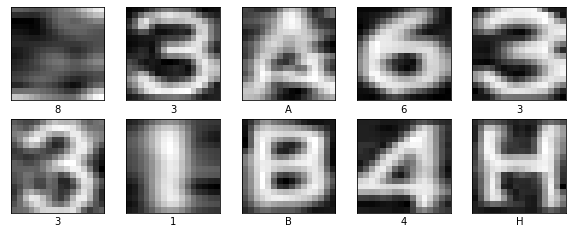

In [19]:
preview_dataset(train_data)

## Dataset image augmentation

#### Augmenting dataset
Introducing variation in the images, such as brightness/contrast change, blurring, flipping and noise addition.

In [20]:
def augment_dataset(
            yolo_dataset: tf.data.Dataset,
            image_shape: Tuple[int, int],
            horizontal_flip_propability: int = 0,
            vertical_flip_propability: int = 0,
            brightness_range: Tuple[int, int] = (0.8, 1.2),
            contrast_range: Tuple[int, int] = (0.8, 1.2),
            blur_probability: int = 0,
            blur_range: Tuple[int, int] = (0.1, 0.2),
            noise_range: Tuple[int, int] = (0.0, 0.0)):

        for batch in yolo_dataset:

            # Setting augmentation parameters
            sequence = ia.augmenters.Sequential([
                # Horizontal flipping
                ia.augmenters.Fliplr(horizontal_flip_propability),

                # Vertical flipping
                ia.augmenters.Flipud(vertical_flip_propability),

                # Brightness increase/decrease
                ia.augmenters.Multiply(brightness_range),

                # Contrast incrase/decrease
                ia.augmenters.contrast.LinearContrast(contrast_range),
                
                # Blur increase
                ia.augmenters.Sometimes(
                    blur_probability,
                    ia.augmenters.GaussianBlur(sigma=blur_range)
                ),
                
                # Noise scale
                ia.augmenters.AdditiveGaussianNoise(scale=noise_range)
            ], random_order=True)

            # Converting Tensor dataset to Numpy array
            images = batch[0].numpy()
            serials = batch[1].numpy()
            
            images = images * 255
            images = images.astype(np.uint8)
            
            # Performing dataset augmentation
            seq_det = sequence.to_deterministic()
            images_aug = np.clip(seq_det.augment_images(images), 0, 0.0001)

            # Converting Numpy array to Tensor dataset and yeild it
            print(images_aug / 255)
            yield (tf.convert_to_tensor(images_aug / 255), tf.convert_to_tensor(serials))

In [21]:
# train_data = augment_dataset(train_data, CHARACTER_SHAPE)
# test_data = augment_dataset(test_data, CHARACTER_SHAPE)

#### Previewing data from the new augmented dataset
Displaying a given number of batches from the new dataset.

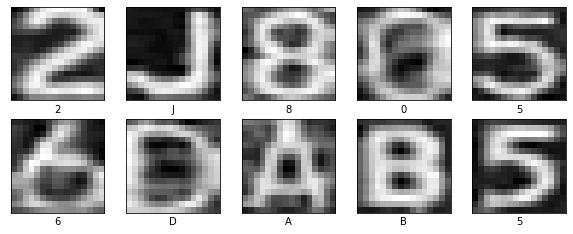

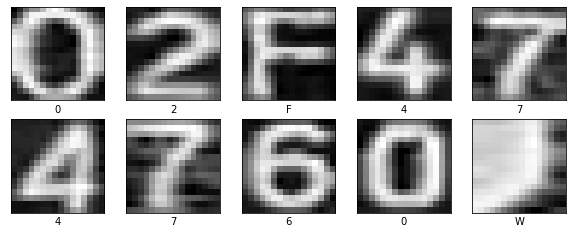

In [22]:
preview_dataset(train_data, 2)

## Character cassification model

#### Model architecture

In [23]:
model = models.Sequential([
    layers.Flatten(input_shape=(CHARACTER_SHAPE[1], CHARACTER_SHAPE[0], 1)),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(len(characterset), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 34)                4386      
Total params: 70,306
Trainable params: 70,306
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [24]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [25]:
detector = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data,
    steps_per_epoch=BATCH_SIZE,
    validation_steps=BATCH_SIZE
)

Train for 128 steps, validate for 128 steps
Epoch 1/128
128/128 [==============================] - 2s 15ms/step - loss: 1.5032 - val_loss: 0.5841
Epoch 2/128
128/128 [==============================] - 0s 3ms/step - loss: 0.4934 - val_loss: 0.3940
Epoch 3/128
128/128 [==============================] - 0s 3ms/step - loss: 0.3909 - val_loss: 0.3307
Epoch 4/128
128/128 [==============================] - 0s 3ms/step - loss: 0.3624 - val_loss: 0.2913
Epoch 5/128
128/128 [==============================] - 0s 4ms/step - loss: 0.3368 - val_loss: 0.2640
Epoch 6/128
128/128 [==============================] - 0s 3ms/step - loss: 0.3015 - val_loss: 0.2608
Epoch 7/128
128/128 [==============================] - 0s 3ms/step - loss: 0.2868 - val_loss: 0.2613
Epoch 8/128
128/128 [==============================] - 0s 3ms/step - loss: 0.2985 - val_loss: 0.2545
Epoch 9/128
128/128 [==============================] - 0s 3ms/step - loss: 0.2599 - val_loss: 0.2436
Epoch 10/128
128/128 [========================

Epoch 81/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1743 - val_loss: 0.1763
Epoch 82/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1907 - val_loss: 0.1676
Epoch 83/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1692 - val_loss: 0.1866
Epoch 84/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1912 - val_loss: 0.1677
Epoch 85/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1803 - val_loss: 0.1651
Epoch 86/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1817 - val_loss: 0.1710
Epoch 87/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1797 - val_loss: 0.1702
Epoch 88/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1806 - val_loss: 0.1610
Epoch 89/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1848 - val_loss: 0.1700
Epoch 90/128
128/128 [==============================] - 0s 3ms/step - loss: 0.1707

#### Model testing

3


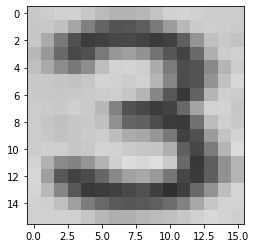

0


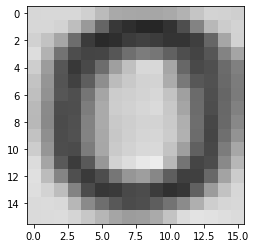

0


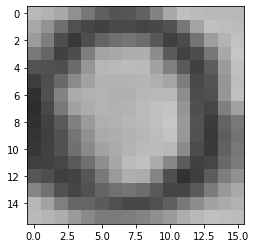

C


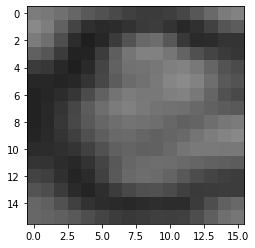

9


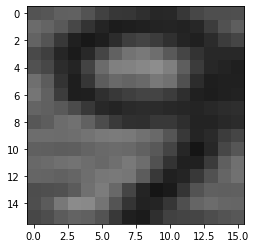

0


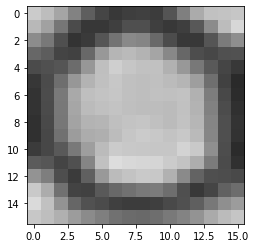

P


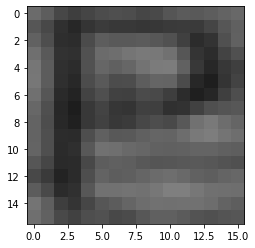

0


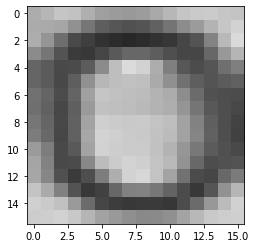

E


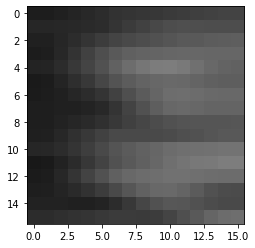

5


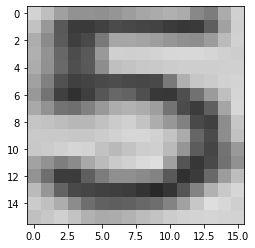

In [26]:
for batch in test_data:
    prediction = model.predict(batch)
    for i in range(10):
        print(serial_decode(prediction[i]))
        img = batch[0][i].numpy()
        img = img.reshape(16, 16)
        plt.imshow(img * 255, cmap='gray', vmin=0, vmax=255)
        plt.show()
    break

#### Model saving

In [27]:
model.save('models/{}/'.format(datetime.now().strftime('%Y_%m_%d__%H_%M_%S')))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/2020_07_06__11_24_04/assets
